<a href="https://colab.research.google.com/github/Egoago/Onlab/blob/main/%C3%96nlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D regression

In [10]:
#@title Imports
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors, patches
from math import ceil
import tensorflow as tf
from tensorflow import norm
from tensorflow.math import reduce_mean, abs
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Input, Dropout, ReLU, Softmax, Concatenate, ELU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.initializers import RandomNormal, Zeros, Constant
import keras
from keras import backend as K
from keras.layers import Layer
import pandas as pd

##Preparing the data

###Control points

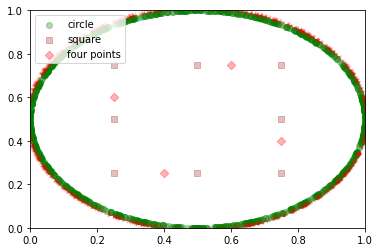

In [11]:
np.random.seed(1)
square = np.array([
                   [0.25,0.25],
                   [0.5,0.25],
                   [0.75,0.25],
                   [0.75,0.5],
                   [0.75,0.75],
                   [0.5,0.75],
                   [0.25,0.75],
                   [0.25,0.5]
                   ])
fourPoints = np.array([
                   [0.4,0.25],
                   [0.75,0.4],
                   [0.6,0.75],
                   [0.25,0.6],
                   ])
fourPointsN = np.array([
                   [-1.0,0.0],
                   [1.0,0.0],
                   [1.0,0.0],
                   [-1.0,0.0],
                   ])
res = 1000
circle = np.empty((res,2))
circleN = np.empty((res,2))
for i in range(res):
  phi = np.random.rand()*2*np.pi
  circle[i] =  [np.cos(phi)/2+0.5, np.sin(phi)/2+0.5]
  circleN[i] = [np.cos(phi), np.sin(phi)]
plt.scatter(circle[:,0], circle[:,1], c='green', marker='o', label='circle', alpha=0.3)
plt.scatter(square[:,0], square[:,1], c='brown', marker='s', label='square', alpha=0.3)
plt.scatter(fourPoints[:,0], fourPoints[:,1], c='red', marker='D', label='four points', alpha=0.3)
plt.quiver(circle[:,0], circle[:,1], circleN[:,0], circleN[:,1], color='red', alpha=0.3)
plt.legend(loc='upper left')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

###Data Scaler

In [12]:
class Scaler():
  def __init__(self, data):
    self.data = data
    self.mean = np.mean(data, axis=0)
    self.scale = np.max(np.abs(data-self.mean))*2
    self.trainingData = self.transform(data)
  
  def getTrainingData(self):
    return self.trainingData

  def getMean(self):
    return self.mean

  def getScale(self):
    return self.scale

  def transform(self, x):
    return (x-self.mean)/self.scale

  def inverse(self, x):
    return x*self.scale+self.mean

###Data generator

In [13]:
class Sampler(Sequence):
  seed = 0
  def __init__(self, batchCount, volumeSampleSize, surfaceSampleSize, controlPoints, controlNormals):
    self.batchCount = batchCount
    self.volumeSampleSize = volumeSampleSize
    self.surfaceSampleSize = surfaceSampleSize
    self.controlPoints = controlPoints
    self.controlNormals = controlNormals
    self.seed = Sampler.seed
    Sampler.seed += 1
    self.randGen = np.random.default_rng(seed=self.seed)

  def __len__(self):
    return self.batchCount

  def __getitem__(self, idx):
    samples = self.randGen.random((self.volumeSampleSize,2))*2-1
    surfaceIndices = self.randGen.choice(self.controlPoints.shape[0],
                                         self.surfaceSampleSize)
    if controlNormals is not None:
      return samples, self.controlPoints[surfaceIndices], self.controlNormals[surfaceIndices]
    else:
      return samples, self.controlPoints[surfaceIndices]

  #def on_epoch_end(self):
    #self.randGen = np.random.default_rng(seed=self.seed)

##Creating model

In [14]:
class CustomModel(Model):
  def __init__(self, eikonalLambda = 0.1, normalLambda = 1, *args, **kwargs):
    super(CustomModel, self).__init__(*args, **kwargs)
    self.eikonalLambda = eikonalLambda
    self.normalLambda = normalLambda
    self.initialWeights = self.get_weights()

  def train_step(self, data):
    if self.useNormals:
      volumePoints, surfacePoints, surfaceNormals = data
    else:
      volumePoints, surfacePoints = data
    trainableVariables = self.trainable_variables

    with tf.GradientTape() as backpropTape:
      backpropTape.watch(trainableVariables)

      #Volume-eikonal
      with tf.GradientTape() as eikonalTape:
        eikonalTape.watch(volumePoints)
        volumePred = self(volumePoints, training=True)
      volumeGrad = eikonalTape.gradient(volumePred, volumePoints)
      eikonalLoss = tf.cast(reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2), dtype='float32')

      #Surface
      with tf.GradientTape() as surfaceTape:
        surfaceTape.watch(surfacePoints)
        surfacePred = self(surfacePoints, training=True)
      surfaceAbs = abs(surfacePred)
      if self.useNormals:
        surfaceGrad = surfaceTape.gradient(surfacePred, surfacePoints)
        surfaceAbs += self.normalLambda*norm(surfaceGrad-surfaceNormals, 2, -1)
      surfaceLoss = reduce_mean(surfaceAbs)

      loss = surfaceLoss + self.eikonalLambda * eikonalLoss

    self.optimizer.minimize(loss, trainableVariables, tape=backpropTape)
    return {"loss": loss}
  
  def test_step(self, data):
    volumePoints, surfacePoints, surfaceNormals = data

    #Volume-eikonal
    with tf.GradientTape() as eikonalTape:
      eikonalTape.watch(volumePoints)
      volumePred = self(volumePoints, training=True)
    volumeGrad = eikonalTape.gradient(volumePred, volumePoints)
    eikonalLoss = tf.cast(reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2), dtype='float32')

    #Surface
    with tf.GradientTape() as surfaceTape:
      surfaceTape.watch(surfacePoints)
      surfacePred = self(surfacePoints, training=True)
    surfaceAbs = abs(surfacePred)
    if surfaceNormals is not None:
      surfaceGrad = surfaceTape.gradient(surfacePred, surfacePoints)
      surfaceAbs += self.normalLambda*norm(surfaceGrad-surfaceNormals, 2, -1)
    surfaceLoss = reduce_mean(surfaceAbs)

    loss = surfaceLoss + self.eikonalLambda * eikonalLoss
    return {"loss": loss}
  
  def reset(self):
    self.set_weights(self.initialWeights)
  
  def compile(self, useNormals = False, *args, **kwargs):
    self.useNormals=useNormals
    super(CustomModel,self).compile(*args,**kwargs)

In [15]:
#@title Softer Relu activation { display-mode: "form" }
class SofterRelu(Layer):
  def sRelu(x, beta=100):
    return K.log(K.exp(x*beta) + 1)/beta

  def __init__(self, beta=100, trainable=False, **kwargs):
      super(SofterRelu, self).__init__(**kwargs)
      self.supports_masking = True
      self.beta = beta
      self.trainable = trainable

  def build(self, input_shape):
      self.beta_factor = K.variable(self.beta,
                                    dtype=K.floatx(),
                                    name='beta_factor')
      if self.trainable:
          self._trainable_weights.append(self.beta_factor)

      super(SofterRelu, self).build(input_shape)

  def call(self, inputs, mask=None):
      return SofterRelu.sRelu(inputs, self.beta_factor)

  def get_config(self):
      config = {'beta': self.get_weights()[0] if self.trainable else self.beta,
                'trainable': self.trainable}
      base_config = super(SofterRelu, self).get_config()
      return dict(list(base_config.items()) + list(config.items()))

  def compute_output_shape(self, input_shape):
      return input_shape



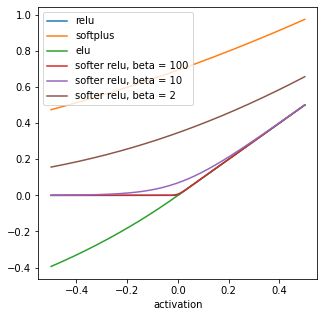

In [16]:
#@title Plotting functions { form-width: "10px", display-mode: "form" }
def plotActivations():
  df = pd.DataFrame({"activation": np.linspace(-0.5,0.5,200)})
  df["relu"] = K.eval(keras.activations.relu(df["activation"]))
  df["softplus"] = K.eval(keras.activations.softplus(df["activation"]))
  df["elu"] = K.eval(keras.activations.elu(df["activation"]))
  df["softer relu, beta = 100"] = K.eval(SofterRelu()(df["activation"]))
  df["softer relu, beta = 10"] = K.eval(SofterRelu(10)(df["activation"]))
  df["softer relu, beta = 2"] = K.eval(SofterRelu(2)(df["activation"]))
  df.plot(x="activation", figsize=(5,5))

def plot(model, controlPoints=None, controlNormals=None, plotSize='big'):
    sizeDict = {
        'big': ((20,15), 200, 0.05,2),
        'medium': ((8,5), 100, 0.12,1),
        'small': ((4,3), 40, 0.2,1),
    }
    figSize, resolution, lineDensity, scale = sizeDict[plotSize]
    plt.figure(figsize=figSize)
    grid = np.empty((resolution*resolution,2))
    for y in range(resolution):
      for x in range(resolution):
        grid[y*resolution+x] = [(x/resolution-0.5)*2*scale, (y/resolution-0.5)*2*scale]
    prediction = np.array(model.predict(grid).reshape((resolution,resolution)))
    grid = []

    max = np.max(prediction)
    min = np.min(prediction)
    if (abs(min) > max):
      max = abs(min)
    im = plt.imshow(prediction,
            cmap = sns.diverging_palette(220, 20, as_cmap=True),
            origin='lower',
            norm = colors.Normalize(vmin=-max, vmax=max),
            extent=(-scale,scale,-scale,scale))
    plt.colorbar(im)
    cset = plt.contour(prediction,
                       np.arange(-1.5,1.5,lineDensity),
                       linewidths=2,
                       cmap='gray_r',
                       extent=(-scale,scale,-scale,scale))
    plt.clabel(cset,inline=True,fmt='%1.2f',fontsize=10)
    if controlPoints is not None:
      plt.scatter(controlPoints[:,0],
                  controlPoints[:,1],
                  c='grey', marker='o',
                  label='control points')
      if controlNormals is not None:
        plt.quiver(controlPoints[:,0],
                  controlPoints[:,1],
                  controlNormals[:,0],
                  controlNormals[:,1],
                  color='grey',
                  headlength = 3,
                  scale = 15,
                  headaxislength=3)
    if plotSize != 'big':
      plt.axis('off')
    else:
      plt.gca().add_patch(plt.Rectangle((-1,-1),2,2,
                    edgecolor='green',
                    facecolor='none',
                    lw=4, alpha=0.5))
      plt.contour(prediction,
                       0,
                       linewidths=4,
                       cmap='gray_r',
                       extent=(-scale,scale,-scale,scale))
    prediction = []
    plt.show()

class PlotCallback(Callback):
  def __init__(self, model, controlPoints=None, controlNormals=None, step=2):
    self.model = model
    self.controlPoints = controlPoints
    self.controlNormals = controlNormals
    self.step = step
    self.plots = []

  def on_train_begin(self, logs=None):
    print('Initial weights')
    plot(self.model, controlPoints, controlNormals, plotSize='medium')

  def on_epoch_end(self, epoch, logs=None):
    if (epoch%self.step == 0):
      plot(self.model, controlPoints, controlNormals, plotSize='small')
plotActivations()

Trainable variables: 575


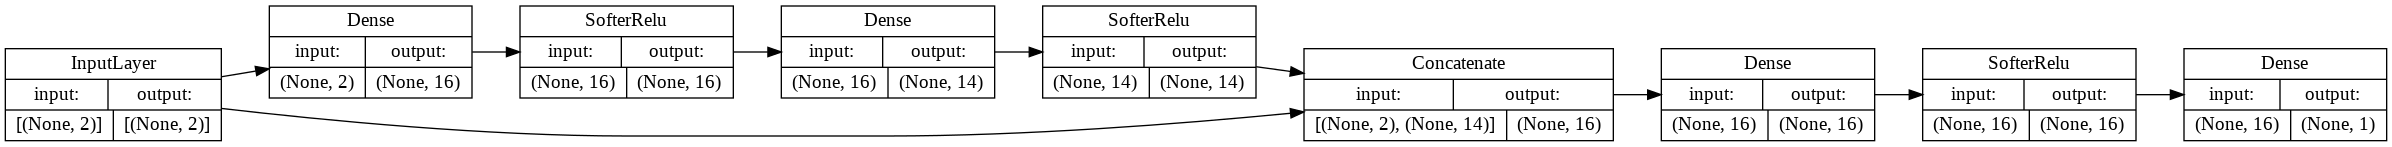

In [17]:
#@title Structure { run: "auto", form-width: "50%", display-mode: "form" }
layerCount = 3 #@param {type:"slider", min:1, max:8, step:1}
skipLayer = 2 #@param {type:"slider", min:0, max:8, step:1}
layerNeurons = 16 #@param {type:"slider", min:8, max:64, step:8}
activation = "softerRelu" #@param ["relu", "softmax", "softerRelu", "elu"]
activationParam = 20 #@param {type:"number"}
learningRate = 0.0015 #@param {type:"slider", min:0.0005, max:0.002, step:0.0001}

def getActivation():
  if activation == "softerRelu":
    return SofterRelu(activationParam)
  elif activation == "elu":
    return ELU(activationParam)
  elif activation == "relu":
    return ReLU()
  elif activation == "softmax":
    return Softmax()

inputLayer = Input(shape=(2,))
prevLayer = inputLayer
for i in range(1,layerCount+1):
  neurons = layerNeurons-2 if i == skipLayer else layerNeurons
  hiddenLayer = Dense(neurons,
                     kernel_initializer=RandomNormal(stddev=np.sqrt(2)/np.sqrt(neurons)),
                     bias_initializer=Zeros())(prevLayer)
  prevLayer = getActivation()(hiddenLayer)
  if i == skipLayer:
    prevLayer = Concatenate()([inputLayer,prevLayer])
outputLayer = Dense(1,
                    activation='linear',
                    kernel_initializer= RandomNormal(mean=np.pi/np.sqrt(neurons), stddev=0.00001),
                    bias_initializer=Constant(-0.5)
                    )(prevLayer)

model = CustomModel(inputs = inputLayer, outputs = outputLayer)
model.compile(optimizer = Adam(lr = 0.0015))
#model.summary()
print(f'Trainable variables: {np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])}')
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR')


Initial weights


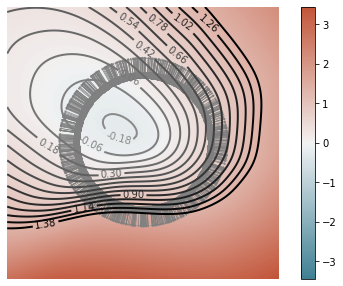

Epoch 1/10
1000/1000 [==============================] - 4s 2ms/step - loss: 0.0582


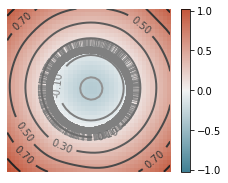

Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0136


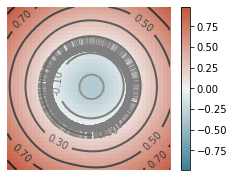

Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0121


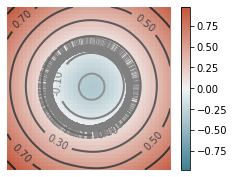

Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0104


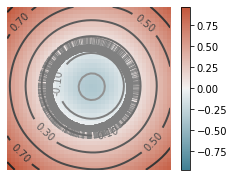

Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0098


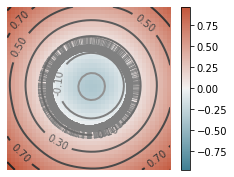

Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0096


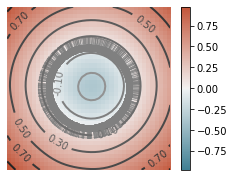

Epoch 7/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0095


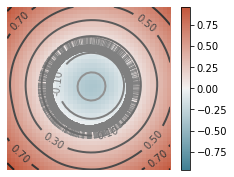

Epoch 8/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0085


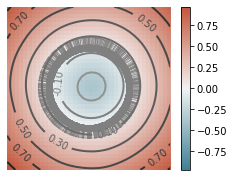

Epoch 9/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0080


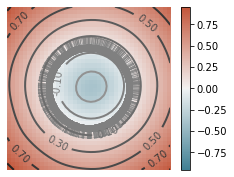

Epoch 10/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0079


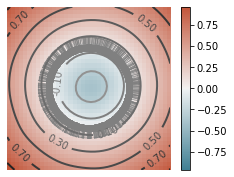

In [20]:
#@title Train
batchCount = 1000 #@param {type:"slider", min:10, max:10000, step:10}
volumeSampleSize = 8 #@param {type:"slider", min:1, max:2048, step:1}
surfaceSampleSize = 8 #@param {type:"slider", min:1, max:2048, step:1}
epochs = 10 #@param {type:"integer"}
useNormals = True #@param {type:"boolean"}
reset = True #@param {type:"boolean"}
save = '' #@param {type:"string"}

scaler = Scaler(circle)
controlPoints = scaler.getTrainingData()
controlNormals = circleN if useNormals else None
if reset:
  model.reset()
model.compile(optimizer = Adam(lr = 0.0015),
              useNormals=useNormals)
history = model.fit(Sampler(batchCount = batchCount,
                                  volumeSampleSize = volumeSampleSize,
                                  surfaceSampleSize = surfaceSampleSize,
                                  controlPoints = controlPoints,
                                  controlNormals = controlNormals),
                    verbose = 1,
                    callbacks = [PlotCallback(model, controlPoints, controlNormals, 1)],
                    epochs = epochs)
if len(save)>0:
  model.save_weights('./saves/' + save)

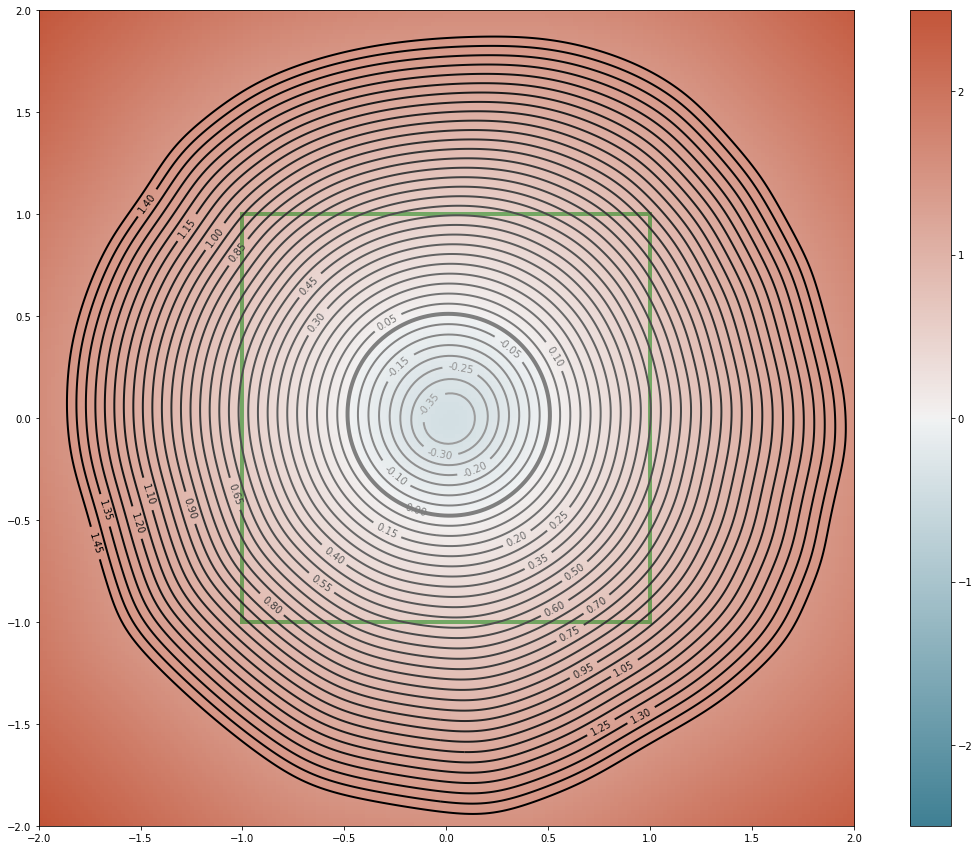

In [22]:
plot(model)